# Costa Rican Household Poverty Level Prediction

참고 : https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

이 대회는 개인과 가구를 활용해 가구의 빈곤 수준을 예측하는 기계학습 모델을 개발하는 것이 목표다.

우선, 문제에 대해 소개를 하고, 데이터셋에 대해 EDA(Exploratory Data Analysis)를 수행하고, feature engineering을 하고, 다중 기계학습 모델을 시도해보고, 모델을 선택하고, 모델을 최적화하고, 마지막으로 모델의 결과를 검토하고 결론을 짓는다.

## Problem and Data Explanation

데이터는 train.csv와 test.csv가 주어진다. train 셋은 9557개 행 143개 열로, test 셋은 23856개 행, 142개 열로 이뤄진다. 각 행은 각 개인을 나타내고, 각 열은 개인당 가구 혹은 개인의 고유한 변수를 나타낸다. train 셋은 빈곤수준이 1-4 크기인 추가적인 target 열이 있다. 1값은 가장 심한 빈곤상태다.

다중 분류 기계학습 문제
- Supervised : train 데이터의 레이블과 함께 제공
- Multi-class classification : 레이블이 4가지인 이산형 값

### Objective

가정의 빈곤을 예측하는 것이 목표다. 고유한 변수를 갖는 각 개인에 대한 데이터와 그들의 가구에 대한 정보가 주어진다. 작업할 데이터셋을 생성하기 위해, 각 가구에 대한 개별 데이터의 집계를 해야한다. test 셋의 모든 개인에 대해 예측해야 하지만, "가구의 가장만 점수에 사용된다". 즉, 가구 단위로 빈곤을 예측할 것이다.

참고 : train 데이터에서 모든 가족 구성원은 동일한 레이블을 가져야하지만, 같은 가구의 개인들이 다른 레이블을 갖는다는 오류가 있다. 이 경우, 각 가정의 가장에 대한 레이블을 사용하는데, parentesco1==1.0인 행으로 식별할 수 있다. 

target값은 다음과 같은 빈곤 수준을 나타낸다.
- 1 : 극취약계층
- 2 : 보통취약계층
- 3 : 취약계층
- 4 : 취약계층이 아님

143개 열 중 주의할 것
- id : 각 개인의 고유 식별자. 사용하지 않는 변수다.
- idhogar : 각 가정에 대한 고유 식별자. 변수는 아니지만, 가구의 모든 개인이 동일한 식별자를 가지므로 가구별 개인을 그룹화하는 데 사용한다.
- parentesco1 : 가정의 가장 여부
- target : 가정의 모든 구성원에 대해 동일해야하는 레이블

모델을 만들 때, 가구별 '가장의 빈곤 수준'을 레이블로 가정을 학습시킨다. 원데이터는 가구와 개인이 섞여있으며, 개인 데이터는 각 가구당 집계할 수 있는 방법을 찾아야한다. 일부 개인은 가장이 없는 가정에 속해있어 이 데이터를 학습시킬 수 없다. 이런 데이터 문제는 현실적인 데이터의 아주 전형적인 문제이므로 데이터사이언스 작업에서 마주치는 데이터셋에 대한 준비가 필요하다.

### Metric

궁극적으로 가정의 빈곤 수준을 예측할 수 있는 기계학습 모델을 구축해야한다. 예측 성능은 Macro F1 Score로 평가될 것이다. precision과 recall의 조화 평균인 이항 분류 문제에 대해 표준 F1 score를 사용한다.

다중 클래스 문제는 각 클래스에 F1 score 평균을 낸다. macro F1 score는 레이블 불균형을 고려하지 않고 각 클래스의 F1 score를 평균 낸다. 즉, macro를 사용할 때('가중화된' 점수를 사용할 때) 각 레이블의 발생 횟수는 계산에 포함되지 않는다. 

## Roadmap

최종 목표는 가정의 빈곤 수준을 예측하는 기계학습 모델이다. 우선 문제와 데이터를 이해해야한다. 한 모델을 '최고'라고 선택하기 전, 수많은 모델을 평가하고, 모델을 만든 후 예측을 검토해야한다. 

로드맵
1. 문제 이해
2. EDA (Exploratory Data Analysis)
3. 기계학습을 위한 데이터셋 생성을 위한 Feature engineering
4. 기본 기계학습 모델 몇 가지 비교
5. 더 복잡한 기계학습 모델 사용
6. 선택한 모델 최적화
7. 모델 예측 검토
8. 결론 도출 및 다음 단계 제시

# 1. Getting Started

문제에 대해 잘 알아봤으므로 EDA와 feature engineering으로 넘어간다. EDA는 feature engineering과 모델링에 사용되는 이상치, 추세, 상관관계, 패턴을 탐색한다. 데이터를 (통계량을 통해) 정량적으로 그리고 (그래프를 통해) 시각적으로 조사한다.

일단 데이터의 잠재적으로 유용한 관계를 파악하면, 일부 feature engineering (기계학습 파이프라인의 가장 중요한 부분)을 하고 기본 모델을 구축할 수 있다. 

시작해보자.

#### Imports

In [41]:
# 데이터 조작
import pandas as pd
import numpy as np
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
# plotting 기본값 설정
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

### Read in Data and Look at Summary Information

In [58]:
pd.options.display.max_columns = 150  ### 표 출력시 최대 열 수

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


130개 integer 열, 8개 float(numeric) 열, 5개 object 열이 있다는 것을 알 수 있다. integer열은 (0 또는 1을 갖는) Boolean 변수 혹은 이산형 순서값을 갖는 순서형 변수를 나타낸다. object 열은 기계학습 모델에 직접 입력할 수 없어 문제가 발생한다.

train보다 행이 많은 test 데이터를 살펴보자. target이 없어 열이 하나 적다.

In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB


#### Integer Columns

integer 열의 고유값 분포를 살펴보자. 각 열에 대해 고유한 값의 수를 세 결과를 bar plot에 표시한다.

Text(0.5, 1.0, 'Count of Unique Values in Integer Columns')

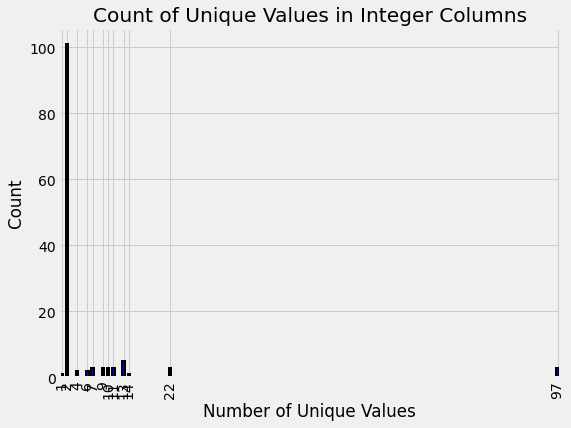

In [61]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='blue', figsize=(8,6), edgecolor='k', linewidth=2)
plt.xlabel('Number of Unique Values')
plt.ylabel('Count')
plt.title('Count of Unique Values in Integer Columns')

고유값이 2개만 있는 열은 Booleans(0 또는 1)을 나타낸다. 이 boolean 정보는 이미 가구 수준에 있다. 예를 들어, refrig 열은 가정에 냉장고가 있는지 여부다. 가구 수준이 나타나는 Boolean에서 변수를 만들 때 이것들을 집계할 필요가 없다. 하지만 개인 수준이 나타나는 Boolean열은 집계해야한다.

#### Float Columns

또 다른 열 유형은 연속형 변수를 나타내는 float이다. 분포도를 통해 모든 float 열의 분포를 보자. key와 value를 지정한 같은 순서로 유지하는 (일반적인 python의 딕셔너리와 달리) OrderedDict를 사용해 빈곤 수준을 색상을 지정해 시각화해보자.

다음 그래프는 target값으로 색상이 지정된 float 열의 분포를 보여준다. 이런 plot을 통해 가구의 빈곤 수준에 따라 변수 분포에 큰 차이가 있는지 확인할 수 있다.

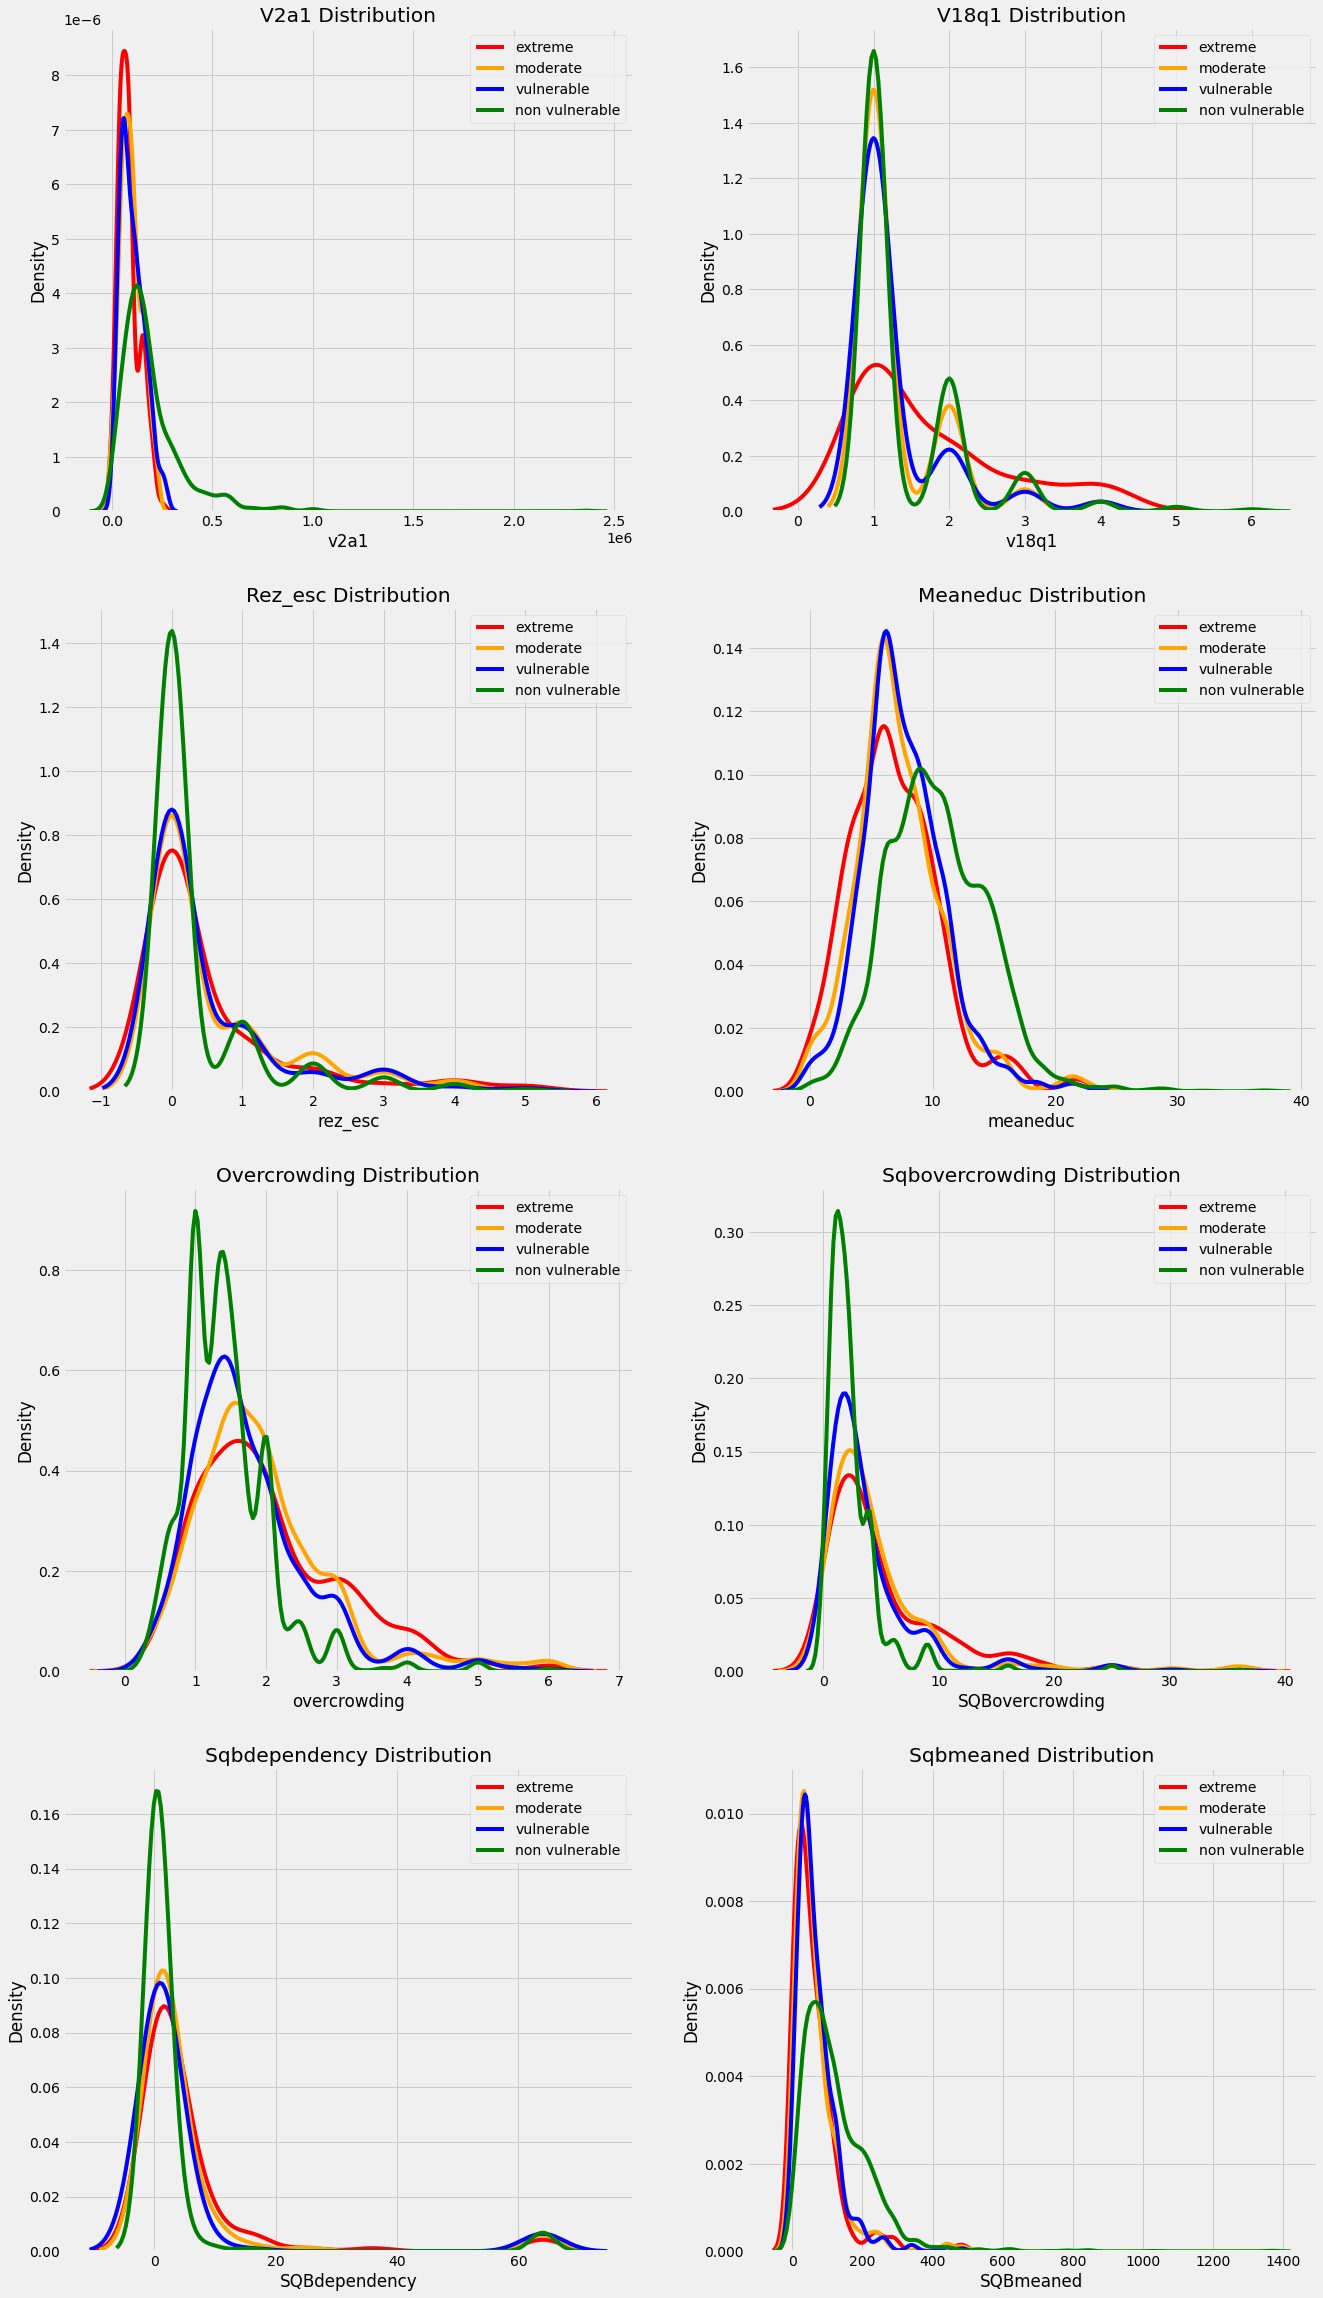

In [62]:
from collections import OrderedDict

plt.figure(figsize=(20,16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1:'red', 2:'orange', 3:'blue', 4:'green'})
poverty_mapping = OrderedDict({1:'extreme', 2:'moderate', 3:'vulnerable', 4:'non vulnerable'})

# float 열 반복
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4,2,i+1)
    # poverty 수준 반복
    for poverty_level, color in colors.items():
        # 개별 선으로 빈곤 수준 시각화
        sns.kdeplot(train.loc[train['Target']==poverty_level,col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()
        
plt.subplots_adjust(top=2)

나중에 변수와 target값간 상관관계를 계산해 변수간 관계를 살펴볼 것이지만, 위의 그래프를 통해 어느 변수가 모델에 가장 "관련된" 변수인지 파악할 수 있다. 예를 들어, 가정 내 성인의 평균 교육을 나타내는 meaneud 변수는 빈곤 수준과 관련있어 보인다. 즉, 평균 성인 교육이 높을수록 target값이 높다(빈곤이 덜한 수준). 교육의 중요성은 나중에 다시 보자.

#### Object Columns

In [63]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


id와 idhogar의 object 타입은 식별 변수이므로 의미가 있다. 그러나 다른 열은 기계학습을 하기 전 처리해야할 문자열과 숫자의 혼합인 것 같다. 
- dependency : 의존율. (19세 이하, 64세 이상 가구원수) / (19~64세 가구원수)
- edjefe : 남성 가장의 교육년도. 가장의 escolari(교육년도)와 성별의 상호작용에 기반. yes=1, no=0
- edjefa : 여성 가장의 교육년도. 가장의 escolari(교육년도)와 성별의 상호작용에 기반. yes=1, no=0

이 세 변수를 매핑을 사용해 수정하고 float으로 변환할 수 있다.

In [64]:
mapping = {'yes':1, 'no':0}

# train, test에 같은 작업 적용
for df in [train, test]:
    # 값을 옳은 mapping으로 채움
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)
    
train[['dependency','edjefa','edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


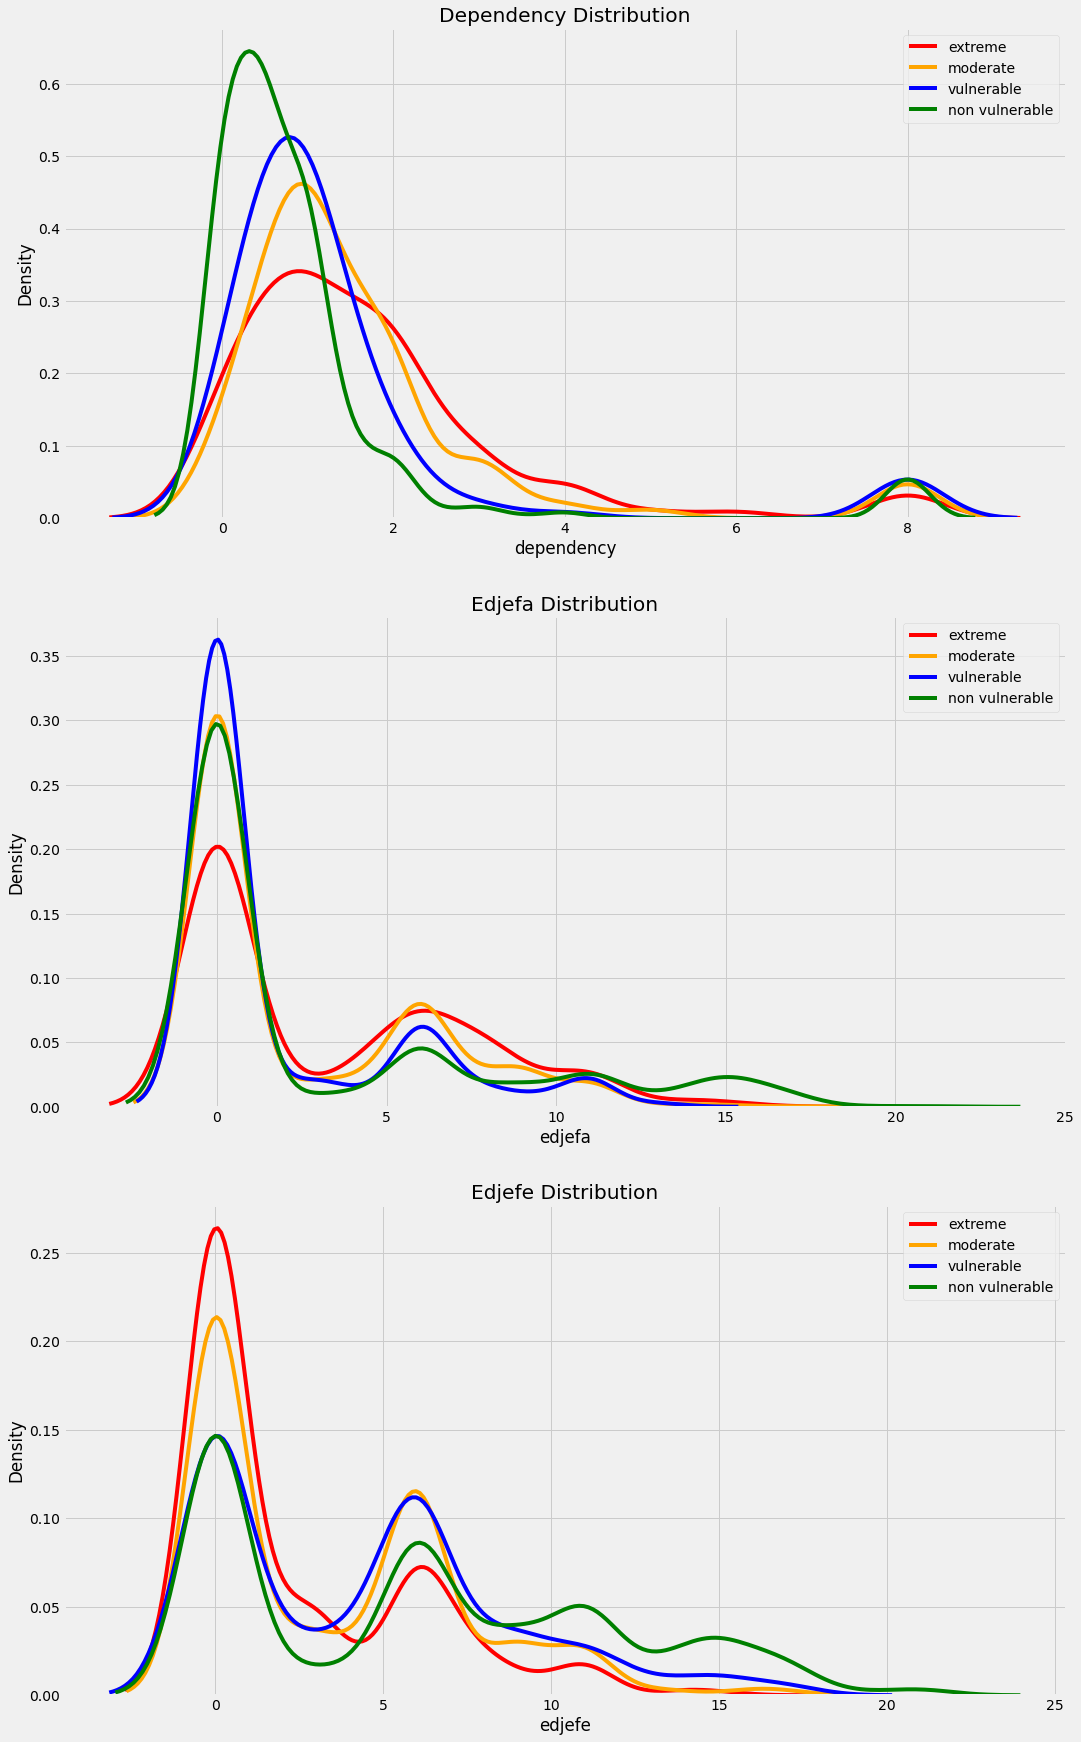

In [70]:
plt.figure(figsize=(16,12))

# float 열 반복
for i, col in enumerate(['dependency','edjefa','edjefe']):
    ax = plt.subplot(3,1,i+1)
    # 빈곤 수준 반복
    for poverty_level, color in colors.items():
        # 개별 선으로 빈곤 수준 시각화
        sns.kdeplot(train.loc[train['Target']==poverty_level,col].dropna(),
                   ax=ax, color=color, label=poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.legend()

plt.subplots_adjust(top=2)

이제 위의 변수들이 숫자로 올바르게 나타나고 기계학습 모델에 입력할 수 있게 됐다.

위와 같은 작업을 더 쉽게 하기 위해, train, test 데이터프레임을 join한다. 이는, 두 데이터프레임에 동일한 작업을 적용해 같은 변수를 사용할 수 있어야하므로 feature engineering을 할 때 중요하다. 나중에 Target에 따라 데이터셋을 분리할 수 있다.

In [66]:
# test에 null값인 Target 열 추가
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

## Exploring Label Distribution

레이블의 분포 통해 문제가 얼마나 불균형한지 알 수 있다. 4가지 빈곤 수준을 나타내는 integer 수준이 4개 있다. 올바른 레이블을 보기 위해, 각 가정의 옳은 레이블인 가장이 해당되는 parentesco1==1인 열만 하위 집합으로 취한다. 

아래 bar plot은 train 레이블의 분포를 보인다(test 레이블이 없으므로).

1.0     222
2.0     442
3.0     355
4.0    1954
Name: Target, dtype: int64

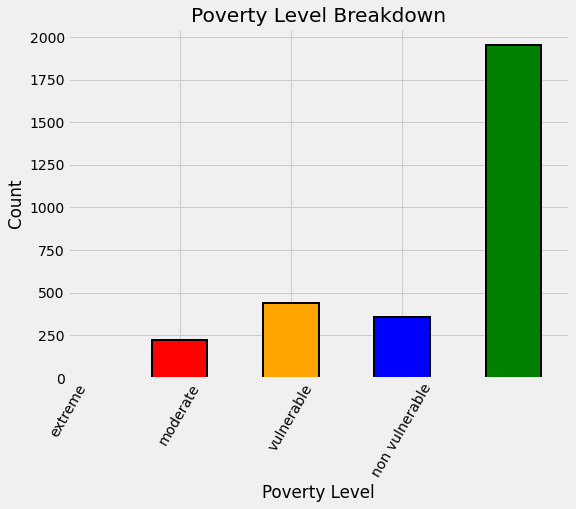

In [72]:
# 가장
heads = data.loc[data['parentesco1']==1].copy()
# trian 의 레이블  ### Target이 결측이 아니고 가장(parentesco==1)인 Target, idhogar값
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1']==1), ['Target','idhogar']]
# target값 count
label_counts = train_labels['Target'].value_counts().sort_index()

# 각 레이블의 bar plot
label_counts.plot.bar(figsize=(8,6),color=colors.values(),edgecolor='k',linewidth=2)
plt.xlabel('Poverty Level')
plt.ylabel('Count')
plt.xticks([x-1 for x in poverty_mapping.keys()], list(poverty_mapping.values()), rotation=60)
plt.title('Poverty Level Breakdown')

label_counts

불균형 클래스 문제를 다루고 있다(가중치 F1 대신 macro F1 score를 선택한 이유와 관련있다). 비취약계층으로 분류되는 가구가 다른 범주보다 훨씬 많다. 극취약계층은 가장 적다.

불균형 분류 문제의 한 가지 문제는 기계학습 모델이 훨씬 적은 클래스를 예측하기 어려울 수 있다는 것이다. 클래스 불균형 문제를 해결하는 방법 중 하나는 오버샘플링이다.

## Addressing Wrong Labels

실제 데이터셋처럼 Costa Rican Poverty 데이터도 몇가지 문제가 있다. 이상치나 오류를 수정해야할 수 있다. 이건 인간의 입력 오류, 측정 오류, 옳은 값이지만 눈에 띄는 극단치일 수 있다. 여기선 동일한 가구의 개인별 빈곤 수준이 다르기 때문에 레이블의 일부는 정확하지 않다. 따라서 가장을 옳은 레이블로 보자.

### Identify Errors

우선 오류를 찾아야한다. 다른 레이블을 가진 가족 구성원이 있는 가구를 찾기 위해, 가구별로 데이터를 그룹화하고 Target의 고유값이 하나만 있는지 확인해본다.

In [73]:
# 가구별 그룹화 및 고유값 수 표시
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
# target이 동일하지 않은 가구
not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.


예시를 하나 보자.

In [74]:
train[train['idhogar']==not_equal.index[0]][['idhogar','parentesco1','Target']]

,idhogar,parentesco1,Target
7651,0172ab1d9,0,3
7652,0172ab1d9,0,2
7653,0172ab1d9,0,3
7654,0172ab1d9,1,3
7655,0172ab1d9,0,2


주최측에서 올바른 레이블은 가장(parentesco1==1)의 레이블이라고 한다. 이 가정의 경우, 모든 구성원의 올바른 레이블은 3이다. 이 가정의 모든 구성원에게 올바른 빈곤수준을 재할당해 옳게 바꿀 수 있다. 

### Families without Heads of Household

가장이 없는 가정이 있다면, 가구원의 레이블이 다를 경우 불일치를 어떻게 해결하는지 알아보자.

In [75]:
households_leader = train.groupby('idhogar')['parentesco1'].sum()  ### 가구별 총 가장 수
# 가장 없는 가정
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader==0].index),:] ### 총 가장 수가 0인 가정

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

There are 15 households without a head.


In [77]:
# 레이블이 다른 가장 없는 가정
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
print('{} Households with no head have different lables.'.format(sum(households_no_head_equal==False)))

0 Households with no head have different lables.


다행히 가장이 없고 구성원의 레이블이 다른 값인 가정을 고려할 필요가 없다. 주최측에 따르면 가장이 없는 가정은 참인 레이블이 없다. 따라서 실제로 학습하는 데 가장 없는 가정은 사용하지 않는다.

### Correct Errors

이제 가장이 있는 가정과 구성원의 빈곤 수준이 다른 레이블을 수정한다.

In [79]:
# 각 가정 반복
for household in not_equal.index:  ### 빈곤수준이 다른 가정 반복
    # 옳은 레이블 찾기 (가장)
    true_target = int(train[(train['idhogar']==household) & (train['parentesco1']==1.0)]['Target'])
    # 가정의 모든 구성원에게 옳은 레이블 부여
    train.loc[train['idhogar']==household,'Target'] = true_target
    
# 가구별 그룹화 및 고유값 표시
all_equal = train.groupby('idhogar')['Target'].apply(lambda x:x.nunique()==1)
# target이 동일하지 않은 가정
not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 0 households where the family members do not all have the same target.


가장의 레이블만 사용할 예정이므로 이 단계가 꼭 필요한 건 아니지만 실제 발생할 수 있는 데이터 오류를 수정하는 것을 보여준다.

## Missing Variables

EDA에서 결측값 처리는 중요한 단계다. 결측값은 기계학습 모델을 사용하기 전 채워야한다. 이를 위해 데이터 정의를 살펴본다.

먼저 각 열의 결측값의 백분율을 확인한다.

In [80]:
# 각 열의 결측값 수
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})
# 결측값 백분율 생성
missing['percent'] = missing['total'] / len(data)
missing.sort_values('percent', ascending=False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000


test 데이터에 NaN을 만들었으므로 Target은 걱정하지 않아도 된다. 그러나 결측값 비율이 높은 나머지 3개 열을 처리해야 한다.

v18q1 : 태블릿 수

가족이 소유한 태블릿 수를 나타내는 v18q1부터 살펴보자. 이 변수의 값 개수를 확인할 수 있다. 이것은 가정 변수이므로 가장의 행만 선택한다.

### Function of Plot Value Counts

서로 다른 열에 대한 값의 개수를 표시하기 위한 간단한 함수를 생성한다.

In [81]:
# 가장만 선택한 열의 값 개수 plot
def plot_value_counts(df, col, heads_only=False):
    # 가장만 선택
    if heads_only:
        df = df.loc[df['parentesco1']==1].copy()
        
    plt.figure(figsize=(8,6))
    df[col].value_counts().sort_index().plot.bar(color='blue',edgecolor='k',linewidth=2)
    plt.xlabel(f'{col}')
    plt.title(f'{col} Value Counts')
    plt.ylabel('Count')
    plt.show()

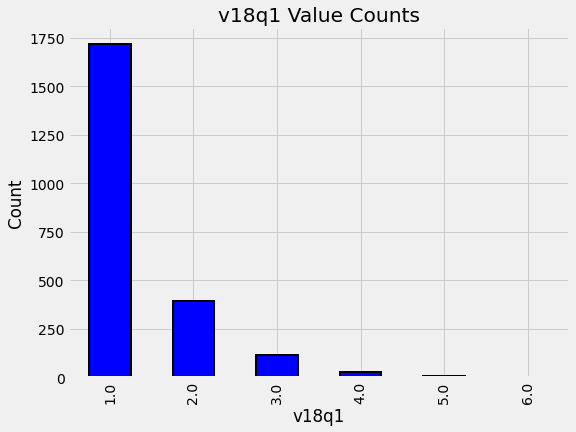

In [82]:
plot_value_counts(heads, 'v18q1')

존재하는 (결측 아닌) 데이터만 보면 가장 많이 소유한 태블릿 개수는 1개인 것 같다. 하지만 결측 데이터도 생각해봐야한다. 이 경우, 범주에 nan값이 있는 가족은 태블릿을 소유하지 않은 것일 수 있다.

v18q값(태블릿 소유하면 1, 아니면 0)으로 그룹화하고 v18q1의 결측값 수를 계산할 수 있다. 이를 통해 null값이 가족이 태블릿을 소유하지 않은 것인지를 나타낸다.

In [83]:
heads.groupby('v18q')['v18q1'].apply(lambda x:x.isnull().sum())

v18q
0    8044
1       0
Name: v18q1, dtype: int64

v18q1이 nan인 가족은 모두 태블릿을 소유하지 않는다. 따라서 이 결측값을 0으로 채울 수 있다.

In [84]:
data['v18q1'] = data['v18q1'].fillna(0)

v2a1 : 월세 납부

다음 결측 열은 월세 납부를 나타내는 v2a1이다.

월세 납부액의 결측치를 살펴보는 것에 더해, 주택의 소유/임대 현황을 나타내는 tipovivi_열의 분포도 살펴볼 수 있다. 이 plot을 통해 월세 납부가 nan값인 가정의 주택 소유 상태를 본다.

Text(0.5, 1.0, 'Home Ownership Status for Households Missing Rent Payments')

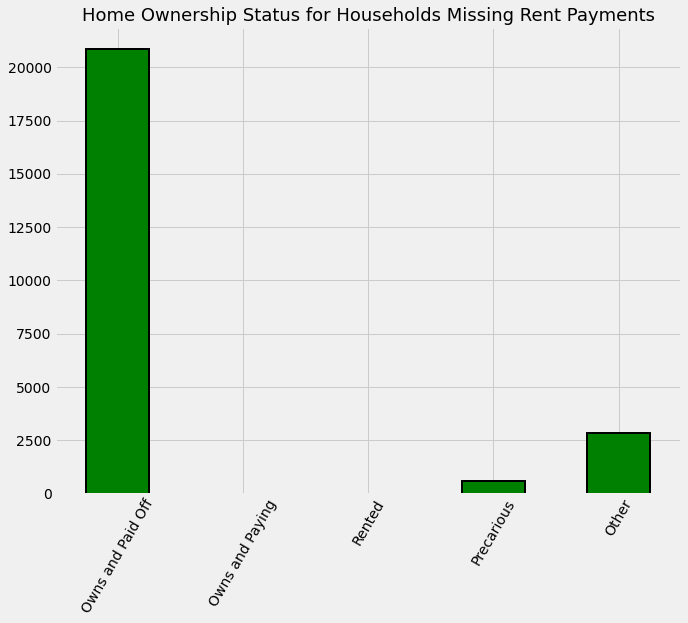

In [85]:
# 주택 소유를 나타내는 변수
own_variables = [x for x in data if x.startswith('tipo')]

# 월세 납부액이 결측인 가정의 주택 소유 변수 plot
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize=(10,8),color='green',edgecolor='k',linewidth=2)
plt.xticks([0,1,2,3,4], ['Owns and Paid Off','Owns and Paying','Rented','Precarious','Other'],rotation=60)
plt.title('Home Ownership Status for Households Missing Rent Payments',size=18)

주택 소유 변수의 의미
- tipovivi1 : 주택 소유 및 납부
- tipovivi2 : 주택 소유 및 할부 결제
- tipovivi3 : 임대
- tipovivi4 : 위태로움
- tipovivi5 : 기타(양도, 임대)

월세를 납부가 없는 가정이 일반적으로 주택을 소유한다. 몇 가지 다른 상황에서는 결측 정보가 있는 이유를 알 수 없다.

주택을 소유하고 월세 납부가 결측인 가정은 납부 값을 0으로 설정할 수 있다. 다른 가정은 결측값을 대체(impute)하기 위해 남겨둘 수 있지만 이러한 가정이 결측값을 갖는다는 것을 나타내는 Boolean 열을 추가해야한다.

In [86]:
# 주택을 소유한 가정의 월세 납부를 0으로 대체
data.loc[(data['tipovivi1']==1), 'v2a1'] = 0

# 결측인 월세 납부 열 생성
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

rez_esc : 학교 다닌 년 수

결측값 비율이 높은 마지막 열은 학교 다닌 년 수를 나타내는 rez_esc이다. 결측값이 있는 가족은 현재 학교에 다니는 아이가 없다는 것을 나타내는 것일 수 있다. 이 열이 결측값인 사람의 나이와 결측값이 없는 사람의 나이를 조사해 알아보자.

In [88]:
data.loc[data['rez_esc'].notnull()]['age'].describe()

count    5832.000000
mean       12.185700
std         3.198618
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

결측값인 가장 오래된 나이가 17살이라는 것을 알 수 있다. 이것보다 나이가 많은 사람은 단순히 학교에 다니지 않는다고 생각할 수 있다. 결측값이 있는 사람들의 나이를 살펴보자.

In [89]:
data.loc[data['rez_esc'].isnull()]['age'].describe()

count    27581.000000
mean        39.110656
std         20.983114
min          0.000000
25%         24.000000
50%         38.000000
75%         54.000000
max         97.000000
Name: age, dtype: float64

이 대회의 토론에서, 이 변수가 7세~19세의 개인에게만 정의된다는 것을 알 수 있다. 이 범위보다 나이가 적거나 많은 사람은 값을 0으로 설정해야한다. 이 변수에서 개인이 19세 이상이고 결측값을 가진다면, 혹은 7세 이하이고 결측값을 가진다면, 0으로 설정할 수 있다. 다른 사람은 값을 대체(imputing)하고 boolean값을 추가한다.

In [90]:
# 19세 이상, 7세 이하며 결측값인 개인 0으로 설정
data.loc[((data['age']>19) | (data['age']<7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0
# 결측값이 있는 7~19세 개인 표시
data['rez_esc-missing'] = data['rez_esc'].isnull()

rez_esc열에는 이상치도 하나 있다. 다시 이 대회의 토론에서 이 변수의 최대값이 5라는 것을 알 수 있다. 따라서 5 이상의 값은 5로 설정한다.

In [91]:
data.loc[data['rez_esc']>5, 'rez_esc'] = 5

## Plot Two Categorical Variables

두 범주형 변수가 서로 상호작용하는 것을 보기 위한 scatterplot, faceted bar plot, boxplot 등 여러가지 plot이 있다. 이것들 외에 다른 함수를 작성한다. 이 함수는 기본적으로 두 범주형 변수의 scatterplot을 그리고, 점의 크기는 각 x값으로 나타나는 주어진 y값의 백분율을 나타낸다.

In [124]:
# 두 범주형 변수의 수 plot. 크기는 각 그룹의 행 수. 백분율은 주어진 y값.
def plot_categoricals(x, y, data, annotate=True):
    # 행 count
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=False))
    raw_counts = raw_counts.rename(columns={x:'raw_count'})
    # x와 y의 각 그룹 개수 계산
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize=True))
    ### normalize=True : 각 그룹화된 값의 전체 대비 비율 = 그룹1의 행수 / 전체행수
    
    # 열 이름 변경 및 인덱스 초기화
    counts = counts.rename(columns={x:'normalized_count'}).reset_index()
    counts['percent'] = 100*counts['normalized_count']
    # 행 수 추가
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize=(14,10))
    # 퍼센트별 크기인 scatterplot
    plt.scatter(counts[x], counts[y], edgecolor='k', color='lightgreen',
               s=100*np.sqrt(counts['raw_count']),marker='o',alpha=0.6,linewidth=1.5)
    
    
    if annotate:  # 주석 달기
        for i, row in counts.iterrows():
            # 텍스트에 적절한 간격 띄우기
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy', text = f"{round(row['percent'], 1)}%")
    
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
                         
    # 최소 최대를 제곱근으로 변환
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
                         
    msizes = list(range(sqr_min, sqr_max, int((sqr_max-sqr_min)/5)))
    markers = []
    for size in msizes:
        markers.append(plt.scatter([],[],s=100*size,label=f'{int(round(np.square(size)/100)*100)}',
                        color='lightgreen',alpha=0.6,edgecolor='k',linewidth=1.5))
            
    plt.legend(handles=markers, title='Counts', labelspacing=3,
              handletextpad=2, fontsize=16, loc=(1.10,0.19))
    plt.annotate(f'*Size represents raw count while % is for a given y value.',
                xy=(0,1), xycoords='figure points', size=10)
                         
    # axes 한계 조정
    plt.xlim((counts[x].min() - (6/counts[x].nunique()),
              counts[x].max() + (6/counts[x].nunique())))
    plt.ylim((counts[y].min() - (4/counts[y].nunique()),
              counts[y].max() + (4/counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}")
    plt.ylabel(f"{y}")
    plt.title(f"{y} vs {x}")

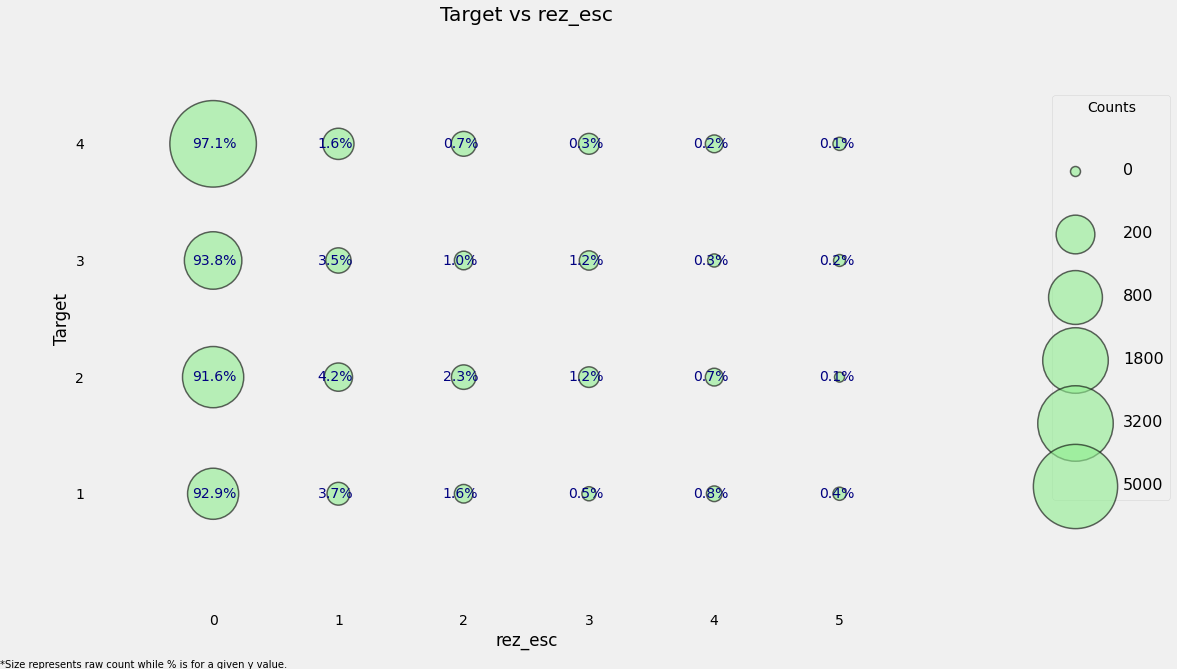

In [125]:
plot_categoricals('rez_esc', 'Target', data)

마커의 크기는 행 수를 나타낸다. 그래프는 y값을 선택하고 행을 가로질러 읽는다. 예를 들어, 빈곤수준이 1인 93%의 개인은 학교를 다니지 않은 사람이 총 800명 정도이고, 약 0.4%인 50명은 5년간 학교를 다녔다. 이 plot은 전체 수와 범주 내 비율을 보여준다. 

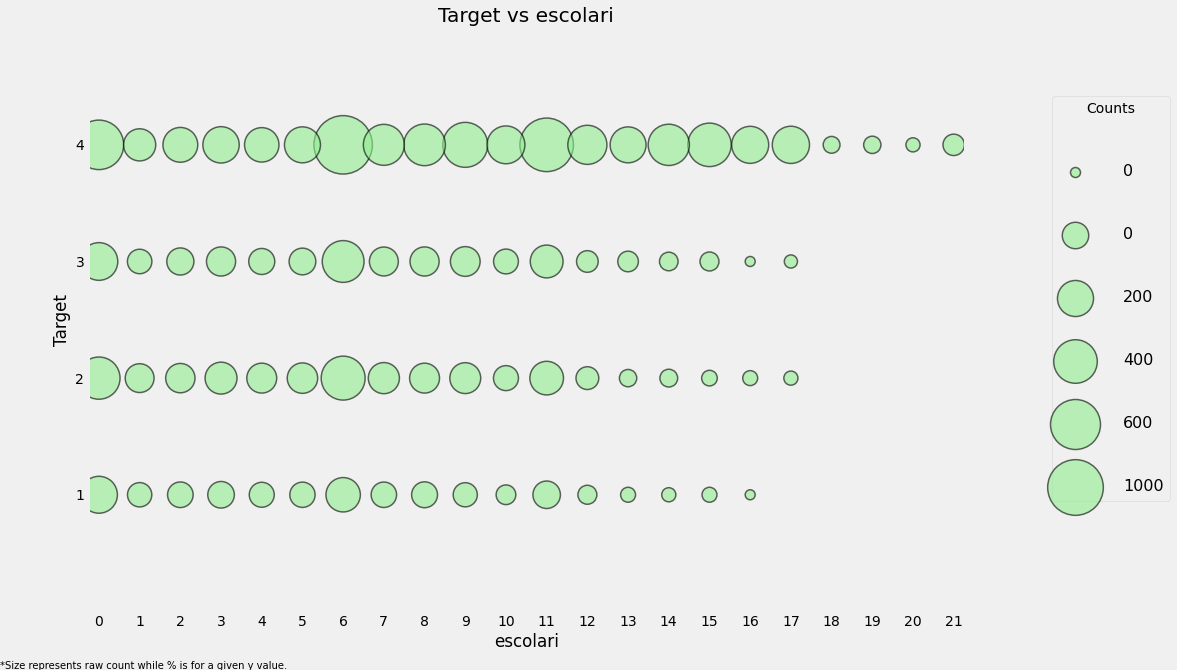

In [126]:
plot_categoricals('escolari','Target',data, annotate=False)

각 열의 결측값은 imputation으로 알려진 과정을 통해 채워진다. 일반적으로 사용되는 imputation은 여러 유형이 있고, 가장 간단하고 효과적인 방법 중 하나는 결측값을 열의 중위수로 채우는 것이다.

결측값의 마지막 단계로, 이러한 값 중 하나가 누락된 경우에 대한 target의 분포를 시각화한다.

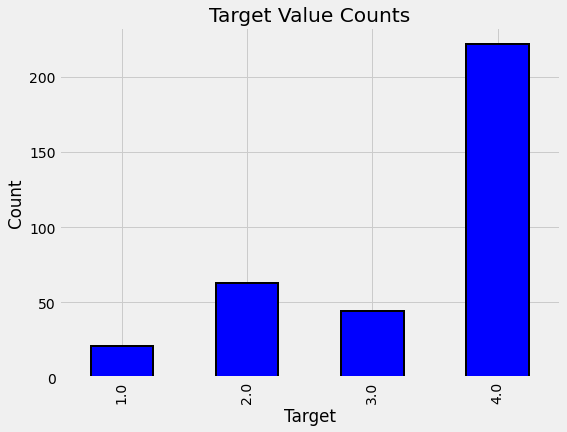

In [127]:
plot_value_counts(data[data['rez_esc-missing']==1],'Target')

분포는 여기서 전체 데이터의 분포와 일치하는 것처럼 보인다.

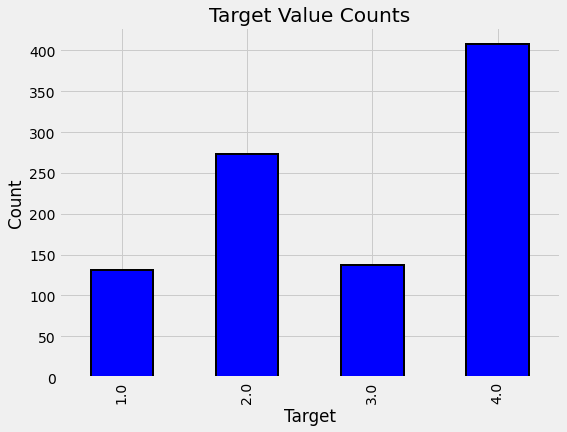

In [128]:
plot_value_counts(data[(data['v2a1-missing']==1)], 'Target')

target=2(보통빈곤)의 비율이 높은 것을 감안하면 더 빈곤한 지표가 될 수 있어 보인다.

이것은 중요한 점을 나타내는데, 때로 결측 정보는 주어진 정보만큼 중요하다.

# 2. Feature Engineering

더 많은 EDA를 할 수 있지만, 먼저 가정 수준에서 데이터를 통합하는 작업을 해야한다. 이미 각 가정에 대한 정보를 일부 갖고 있지만, 학습을 위해 각 가정에 대한 정보가 요약되어야한다. 주택을 소유한 개인을 그룹화하고(groupby) 개인 변수의 집계(agg)를 수행한다는 의미다.

지금은 직접 작업하지만, Featuretools의 자동화된 feature engineering을 사용할 수도 있다.

## Column Definitions

데이터 설명을 사용해 개인 수준과 가정 수준에 있는 열을 정의해야 한다. 데이터 설명에서 변수 자체를 보는 것 외의 수준에 있는 변수를 식별할 수 있는 다른 방법은 없다.
일부 변수를 다양한 방식으로 처리해야하므로 다양한 변수를 정의한다. 각 수준에서 변수를 정의하면 필요에 따라 변수들을 집계할 수 있다.

과정
1. 변수를 가정 수준과 개인 수준으로 세분화
2. 개인 수준 데이터에 적합한 집계 - 순서형 변수는 통계 집계 사용 가능 / Boolean 변수도 집계할 수 있지만 통계량이 적다.
3. 개인 집계를 가정 수준 데이터에 join

### Define Variable Categories

범주형 변수
1. individaul 변수 : 가정이 아닌 각 개인의 특성
- Boolean : Yes, No (0 or 1)
- 순서형 : 순서가 있는 Integer
2. Household 변수
- Boolean : Yes, No
- 순서형 : 순서가 있는 Integer
- 연속형 숫자
3. Squared 변수 : 데이터의 제곱 변수에서 파생
4. ID 변수 : 데이터를 식별하므로 변수로 사용 불가

아래에서 각 범주에서 변수를 수동으로 정의한다.

In [129]:
id_ = ['Id','idhogar','Target']

In [130]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']
ind_ordered = ['rez_esc', 'escolari', 'age']

In [131]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [132]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

모든 변수를 다뤘는지 반복하지 않았는지 확인해보자.

In [133]:
x = ind_bool + ind_ordered + id_ + hh_bool + hh_ordered + hh_cont + sqr_

from collections import Counter
print('There are no repeats :', np.all(np.array(list(Counter(x).values()))==1))
print('We covered every variable :', len(x)==data.shape[1])

There are no repeats : True
We covered every variable : True


#### Squared Variables

먼저, 가장 쉬운 단계로, 모든 제곱 변수를 제거한다. 가끔 선형 모델이 비선형 관계를 학습하는 데 도움이 될 수 있기 때문에 feature engineering의 부분으로, 변수가 제곱되거나 변환된다. 하지만 더 복잡한 모델을 사용할 것이므로 이런 제곱 변수는 중복된다. 제곱되지 않은 것과 높은 상관관계가 있으므로 관련 없는 정보를 추가하고 학습 속도를 늦춰 모델의 성능을 낮출 수 있다.

예를 들어, SQBage와 age를 살펴보자.

Text(0.5, 1.0, 'Squared Age versus Age')

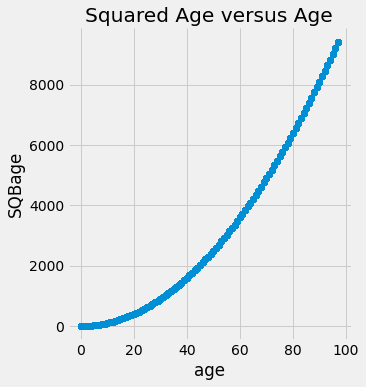

In [136]:
### 임의로 warning 무시
import warnings
warnings.filterwarnings('ignore')

sns.lmplot('age','SQBage', data=data, fit_reg=False)
plt.title('Squared Age versus Age')

이 변수들은 상관관계가 매우 높으므로 데이터에서 둘 다 유지할 필요가 없다.

In [137]:
# 제곱 변수 삭제
data = data.drop(columns=sqr_)
data.shape

(33413, 136)

#### Id Variables

이것은 매우 간단하다. 식별을 위해 필요하므로 데이터에 그대로 유지한다.

#### Household Level Variables

우선 가장으로 그룹화하고 그 다음 가구 수준 변수로 그룹화해보자.

In [140]:
heads = data.loc[data['parentesco1']==1,:]   ### 가장인 데이터
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

대부분의 가구 수준 변수는 그대로 유지할 수 있다. 각 가구에 대해 예측할 것이므로 이 변수들을 그대로 둔다. 하지만 일부 중복 변수를 제거하고 기존 데이터에서 파생된 변수를 추가할 수 있다.

##### Redundant Household Variables

모든 가정 변수 간 상관관계를 살펴보자. 상관관계가 너무 높으면 그 쌍 중 하나를 제거할 수 있다.

다음 코드는 상관관계의 절대값 크기가 0.95 이상인 변수를 식별한다.

In [142]:
# 상관관계 행렬 생성
corr_matrix = heads.corr()
# 상관관계 행렬의 위쪽 삼각형 선택
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
### np.triu : 행렬의 위쪽 삼각형만 선택한 행렬 반환(k=1), k=-1은 모두 선택
### np.ones : np.zeros처럼 1로 채운 배열 생성

# 상관관계가 0.95 이상인 변수 열 인덱스 찾기
to_drop = [column for column in upper.columns if any(abs(upper[column])>0.95)]
to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

각 상관관계가 있는 변수 쌍 중 하나만 보여준다. 다른 쌍을 찾으려면 corr_matrix를 부분집합으로 취한다.

In [143]:
corr_matrix.loc[corr_matrix['tamhog'].abs()>0.9, corr_matrix['tamhog'].abs()>0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


<AxesSubplot:>

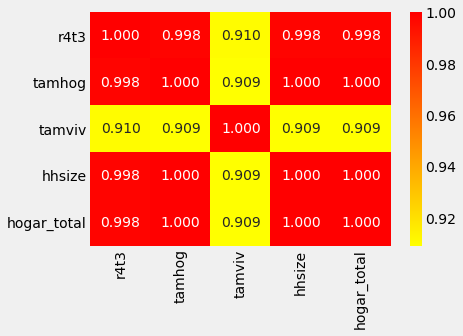

In [144]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs()>0.9, corr_matrix['tamhog'].abs()>0.9],
           annot=True, cmap=plt.cm.autumn_r, fmt='.3f')

집 크기와 관련한 변수가 몇 가지 있다.
- r4t3 : 가정 내 총 인원
- tamhog : 가정 규모
- tamviv : 가정의 살고있는 인원수
- hhsize : 가정 크기
- hogar_total : 가정 내 총 인원수

이러한 변수는 모두 서로 상관관계가 높다. hsize는 tamhog, hogar_total과 완벽한 상관관계를 갖는다. 정보가 중복되므로 이 두 변수를 제거한다. r4t3 또한 hssize와 거의 완벽한 상관관계를 가지므로 제거할 수 있다.

tamviv는 가정에 살고 있지 않은 가족이 있을 수 있으므로 반드시 hhsize와 같진 않다. scatterplot에서 이 차이를 시각화해보자.

In [145]:
heads = heads.drop(columns=['tamhog','hogar_total','r4t3'])

Text(0.5, 1.0, 'Household size vs number of persons living in the household')

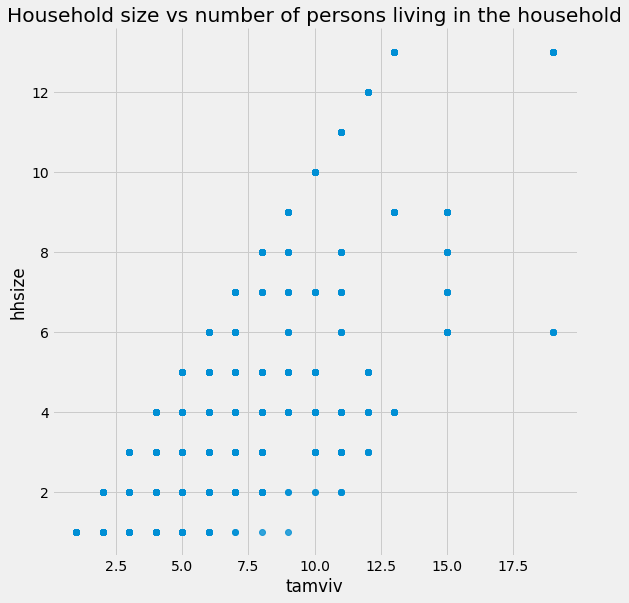

In [146]:
sns.lmplot('tamviv','hhsize',data,fit_reg=False,size=8)
plt.title('Household size vs number of persons living in the household')

대부분의 경우 가족 인원수보다 가정에서 살고있는 사람이 더 많다. 이것은 두 측정치의 차이인 새로운 변수에 대해 아이디어를 제공한다.

새로운 변수를 만들어보자.

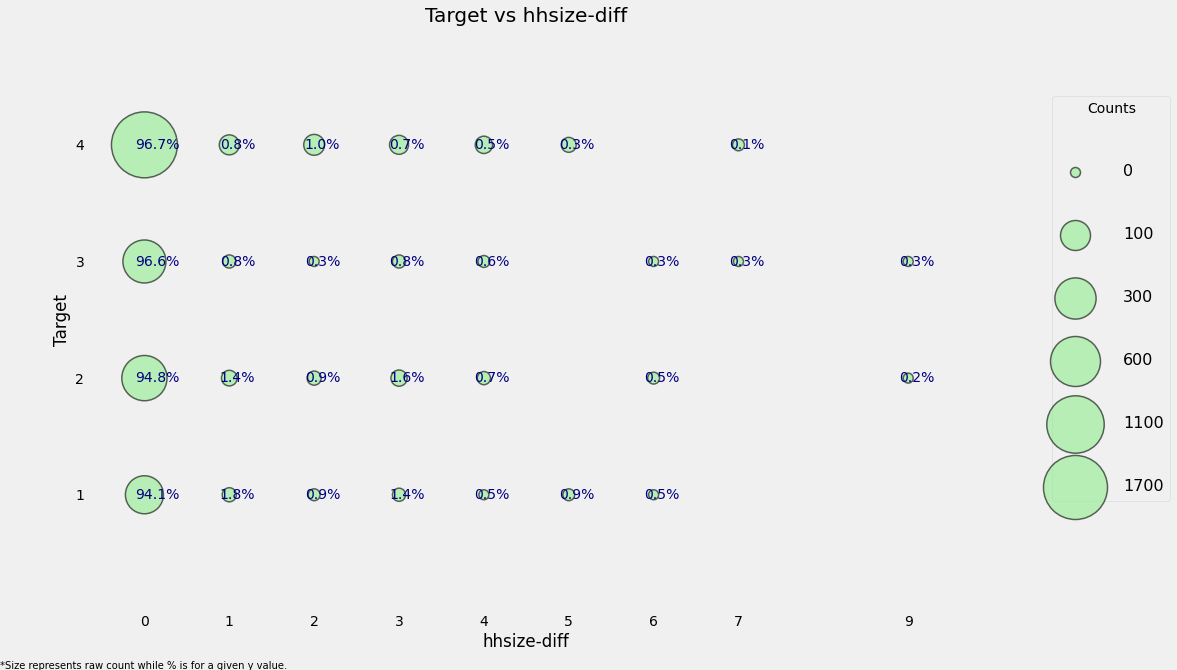

In [147]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']
plot_categoricals('hhsize-diff','Target',heads)

대부분의 가정은 차이가 없지만, 가정에서 살고있는 사람 수가 가정 구성원 수보다 더 많다.

다른 중복 변수로 넘어가보자. 우선 coopele을 볼 수 있다.

In [148]:
corr_matrix.loc[corr_matrix['coopele'].abs()>0.9, corr_matrix['coopele'].abs()>0.9]

,public,coopele
public,1.000000,-0.967759
coopele,-0.967759,1.000000


이 변수들은 가정의 전기가 오는 곳을 나타낸다. 네 가지가 있는데, 이 두 가지 중 하나가 없는 가족은 전기가 없거나(noelec) 개인 공장에서 전기를 공급받는다(planpri).

##### Creating Ordinal Variable

순서형 변수를 만들어 이 네 변수를 하나로 만들어보자.
- 0 : 전기 없음
- 1 : 협동조합의 전기
- 2: CNFL, ICA, ESPH/JASEC의 전기
- 3 : 개인 공장의 전기

순셔형 변수는 고유한 순서를 가진다. 새로운 순서형 변수를 만든 후, 다른 네 개의 변수를 삭제한다. 변수가 없는 여러 가정이 있으므로 nan(imputation으로 채워질)을 사용해 이 변수에 대한 측정치가 없음을 나타내는 Boolean 열을 추가한다.

In [149]:
elec = []

# 값 할당
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    else:
        elec.append(np.nan)
        
# 새 변수 생성 및 결측값 표시
heads['elec'] = elec
heads['elec-missig'] = heads['elec'].isnull()

# electricity 열 삭제
# heads = heads.drop(columns=['noelec','coopele','public','planpri'])

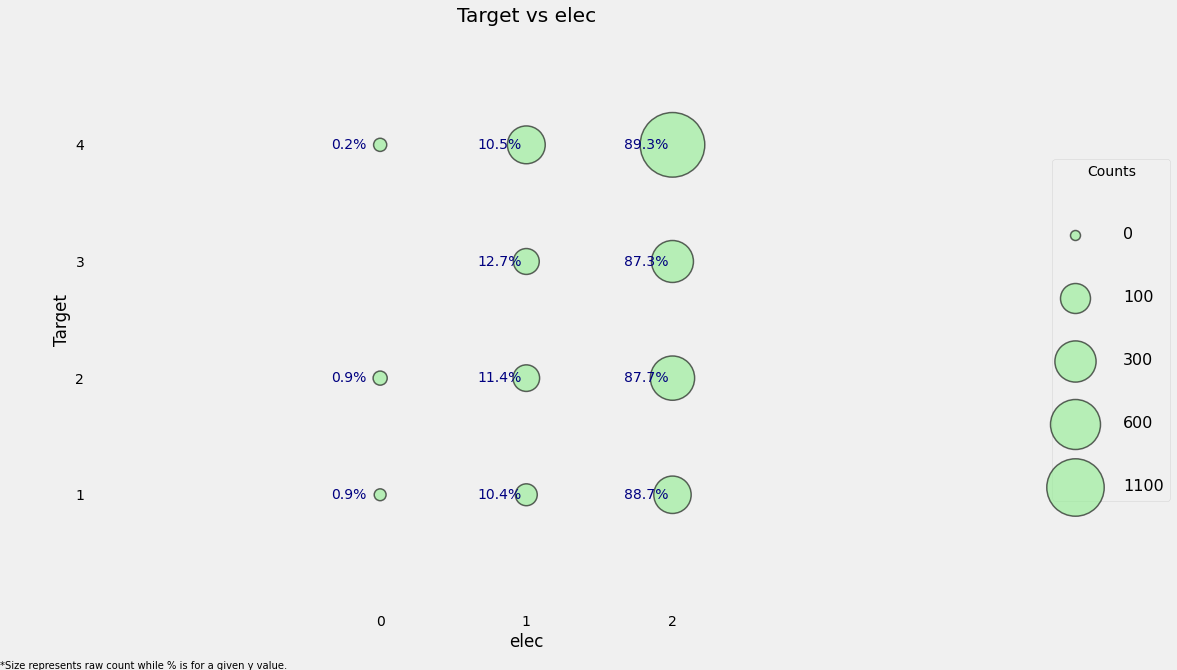

In [150]:
plot_categoricals('elec','Target',heads)

target의 모든 값에 대해 가장 일반적인 전기 공급원은 public 리스트 중 하나다. 

마지막 중복 열은 area2다. 집이 시골에 있다는 것을 의미하지만, 그 집이 도시에 있는지 여부를 나타내는 열이 있어 중복된다. 따라서 이 열을 삭제할 수 있다.

In [152]:
heads = heads.drop(columns='area2')
heads.groupby('area1')['Target'].value_counts(normalize=True)

area1  Target
0      4.0       0.582249
       2.0       0.176331
       3.0       0.147929
       1.0       0.093491
1      4.0       0.687030
       2.0       0.137688
       3.0       0.108083
       1.0       0.067199
Name: Target, dtype: float64

도시 지역(값 1)의 가구가 농촌 지역(값 0)의 가구보다 빈곤 수준이 낮을 가능성이 높아 보인다.

##### Creating Ordinal Variables

집의 벽, 지붕, 바닥은 각 세 개의 열이 있는데, 첫째는 '나쁨',' 둘째는 '보통', 셋째는 '좋음'을 나타낸다. 변수를 boolean으로 남겨놓을 수 있지만, 내재된 순서(나쁨<보통<좋음)가 있으므로 순서형 변수로 바꾸는 것이 더 적합하다. np.armax를 사용해 각 가정에 대해 0이 아닌 열을 간단히 찾을 수 있다.

순서형 변수를 생성하면 원래의 변수를 삭제한다.

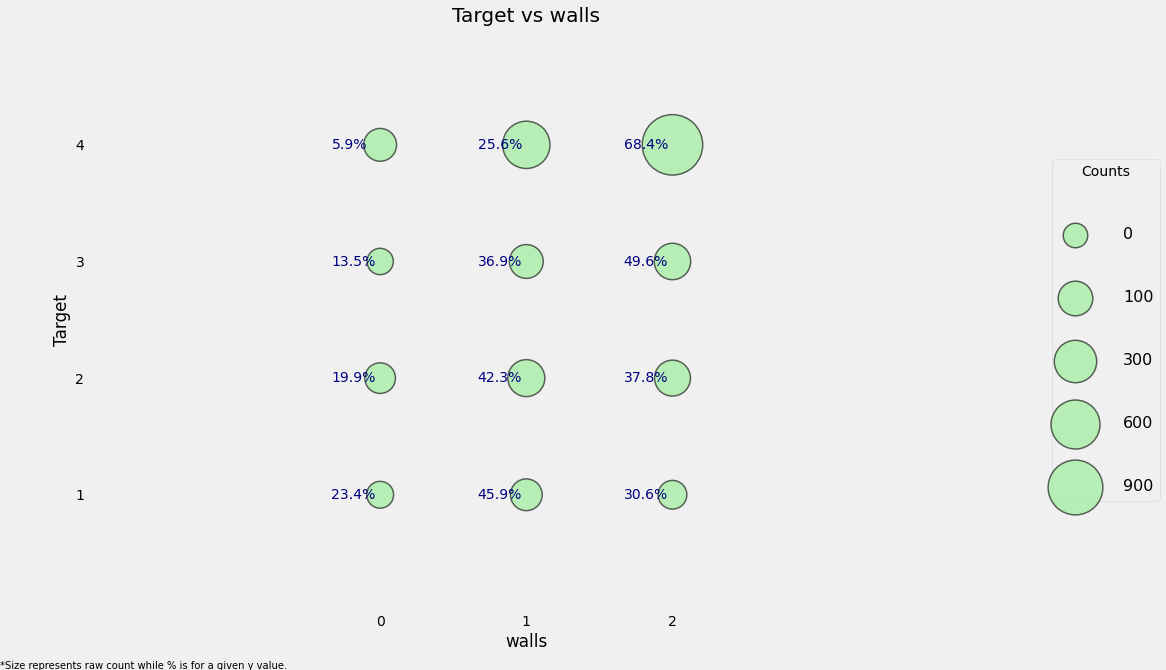

In [153]:
# wall 순서형 변수
heads['walls'] = np.argmax(np.array(heads[['epared1','epared2','epared3']]),axis=1)
# heads = heads.drop(columns=['epared1','epared2','epared3'])
plot_categoricals('walls','Target',heads)

In [155]:
# Roof 순서형 변수
heads['roof'] = np.argmax(np.array(heads[['etecho1','etecho2','etecho3']]),axis=1)
heads = heads.drop(columns=['etecho1','etecho2','etecho3'])

# Floor 순서형 변수
heads['floor'] = np.argmax(np.array(heads[['eviv1','eviv2','eviv3']]),axis=1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Feature Construction

변수를 순서 변수로 매핑하는 것 외에도 기존 데이터에서 새로운 변수를 만드는 feature construction을 할 수 있다. 예를 들어, 방금 만든 이전의 세 변수를 더해 집 구조의 질을 전반적으로 측정할 수 있다.

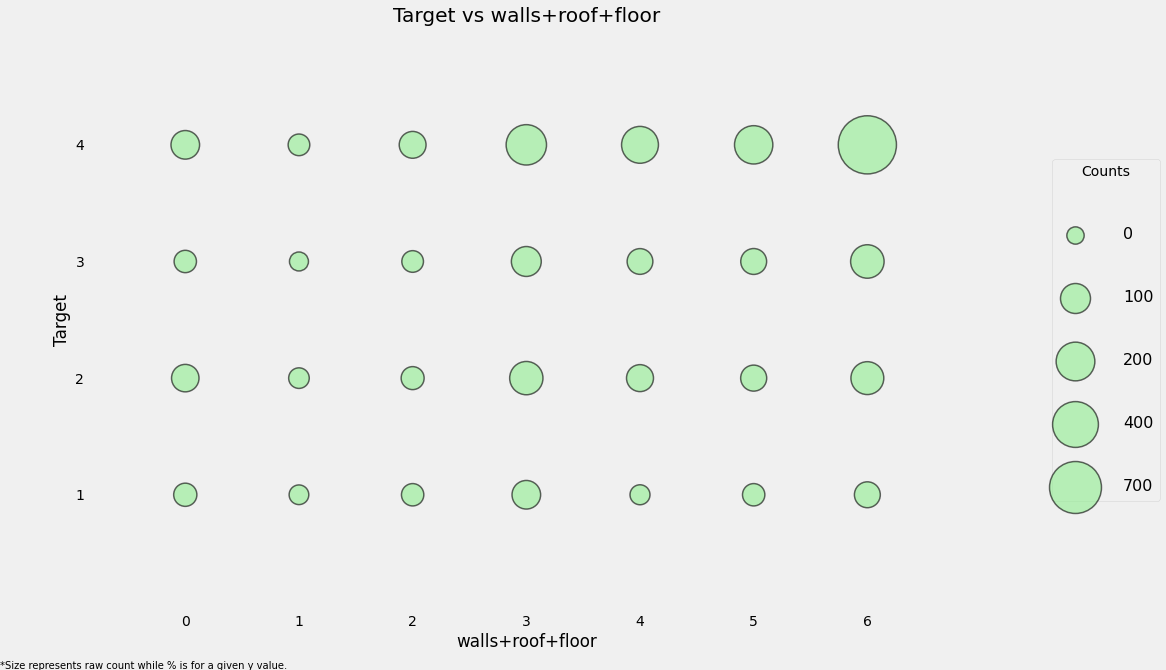

In [156]:
# 새 변수 생성
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']
plot_categoricals('walls+roof+floor','Target',heads,annotate=False)

이 새로운 변수는 Target이 4(가장 빈곤하지 않은 수준)가 '주택 품질' 변수의 값이 더 높은 경향이 있어 유용할 수 있다.

In [157]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize=True)).rename(
    columns={'Target':'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


다음 변수는 집의 품질에 대한 warning이 될 것이다. 화장실, 전기, 바닥, 수도, 천장이 없으면 음수값 -1이다.

In [158]:
heads['warning'] = 1*(heads['sanitario1'] + (heads['elec']==0) 
                      + heads['pisonotiene'] + heads['abastaguano'] + (heads['cielorazo']==0))

이런 관계를 시각화하기 위해 plot_categoricals 함수를 계속 사용할 수 있지만, seaborn은 범주형 변수를 다루는 여러가지 plot option이 있다. 그 중 하나는 y축의 변수 분포를 보여주는 violinplot이고, 각 plot의 너비는 해당 범주의 관측치 수를 나타낸다.

Text(0.5, 1.0, 'Target vs Warning Variable')

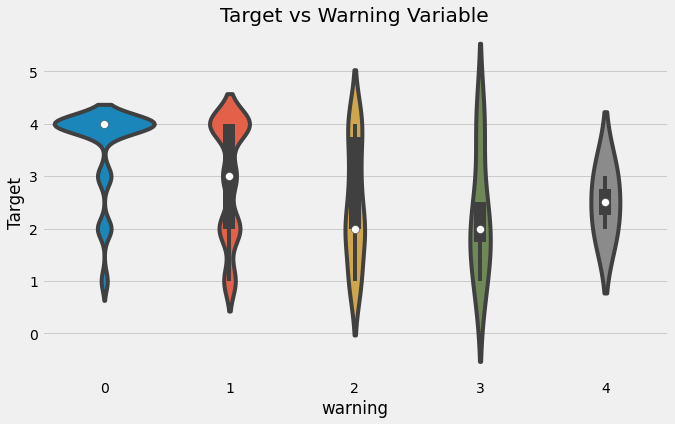

In [159]:
plt.figure(figsize=(10,6))
sns.violinplot(x='warning', y='Target', data=heads)
plt.title('Target vs Warning Variable')

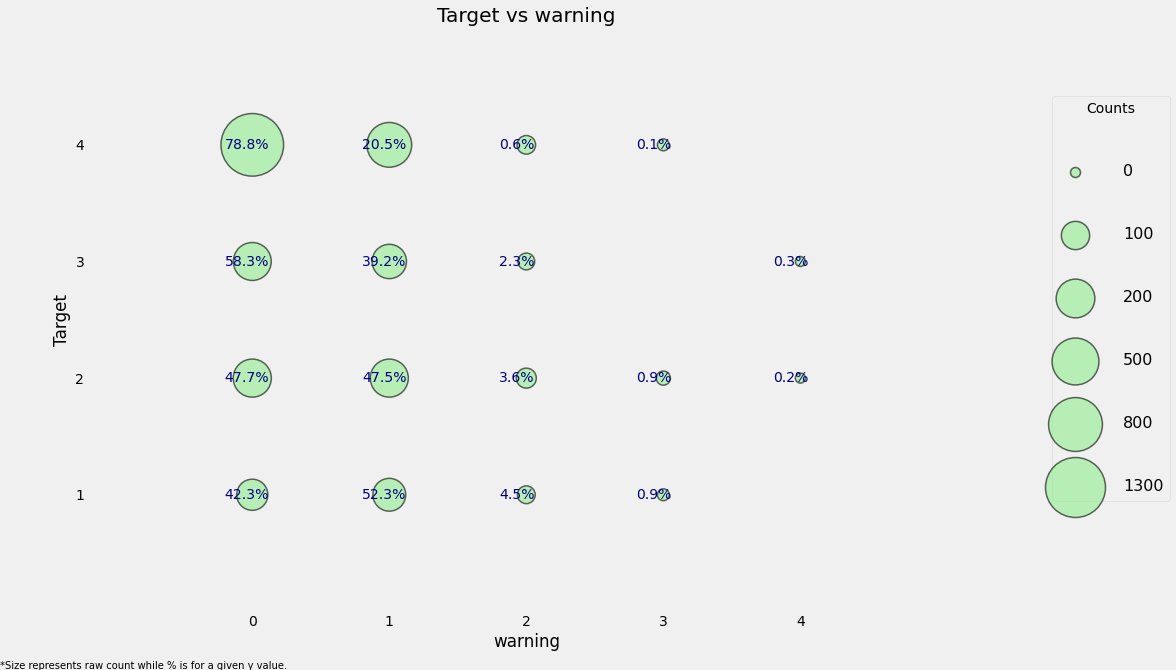

In [160]:
plot_categoricals('warning','Target',data=heads)

violinplot은 실제로 target이 더 작고 큰 값을 취하는 것처럼 보이는 효과로 범주형 변수를 평활화하므로 여기선 좋지 않다. 그럼에도 warning 표시가 없고 빈곤 수준이 가장 낮은 가구의 높은 분포를 볼 수 있다. 이 변수가 유용해 보이지만, 모델링을 하기 전까진 확실하지 않다.

이제 만들 수 있는 마지막 가정 household 변수는 가족이 냉장고, 컴퓨터, 태블릿, 텔레비전을 갖는 포인트를 얻는 bonus다.

Text(0.5, 1.0, 'Target vs Bonus Variable')

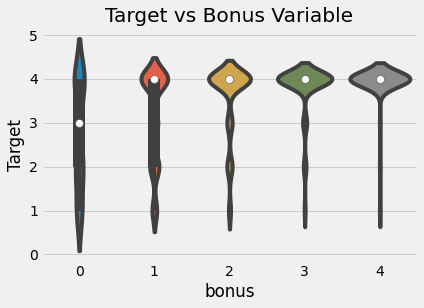

In [161]:
heads['bonus'] = 1*(heads['refrig'] + heads['computer'] 
                    + (heads['v18q1'] > 0) + heads['television'])
sns.violinplot('bonus','Target',data=heads,figsize=(10,6))
plt.title('Target vs Bonus Variable')

## Per Capita Features

만든 추가 변수는 가정의 각 사람에 대해 특정 측정치 수를 계산할 수 있다.

In [162]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

## Exploring Household Variables

이제 Target과 관련된 변수를 살펴보자. 이 관계를 수치화할 수 있다.

### Measuring Relationships

두 변수 사이 관계를 측정하는 방법은 여러가지다. 다음 두 가지를 살펴보자.
1. Pearson 상관관계 : -1부터 1까지 두 변수간 선형 관계를 측정
2. Spearman 상관관계 : -1부터 1까지 두 변수간 단조로운 관계를 측정

Spearman 상관관계는, 관계가 선형적이지 않아도 한 변수가 증가하면 다른 변수도 증가하면 1이다. 반면 Pearson 상관관계는, 증가가 정확히 선형일 경우만 1이다. 아래에서 예시를 보자.

In [164]:
from scipy.stats import spearmanr

In [165]:
# 데이터를 시각화하고 spearman, pearson 상관관계를 표시하는 함수
def plot_corrs(x,y):
    # 상관관계 계산
    spr = spearmanr(x,y).correlation
    pcr = np.corrcoef(x,y)[0,1]
    # scatterplot
    data = pd.DataFrame({'x':x, 'y':y})
    plt.figure(figsize=(6,4))
    sns.regplot('x','y',data=data,fit_reg=False)
    plt.title(f'Spearman: {round(spr,2)}; Pearson: {round(pcr,2)}')

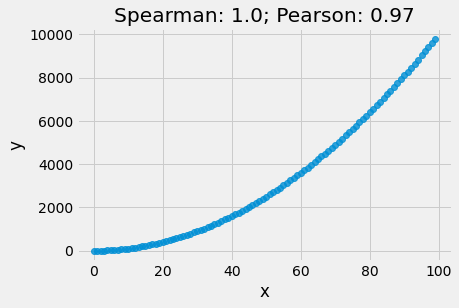

In [167]:
x = np.array(range(100))
y = x**2
plot_corrs(x,y)

### 예시임

Spearman 상관관계는 Target이나 교육년도와 같은 순서형 변수에서 더 좋다. 대부분의 관계는 선형적이지 않고, Pearson 상관관계가 두 변수의 연관성에 근사치가 될 수 있지만 정확하지 않으며 최선의 비교 방법이 아니다.

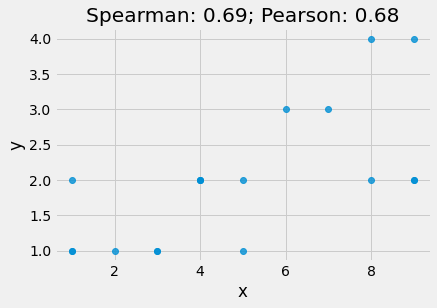

In [168]:
x = np.array([1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9])
y = np.array([1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 3, 2, 4, 2, 2, 4])

plot_corrs(x,y)

대부분의 경우, 값이 매우 비슷하다.

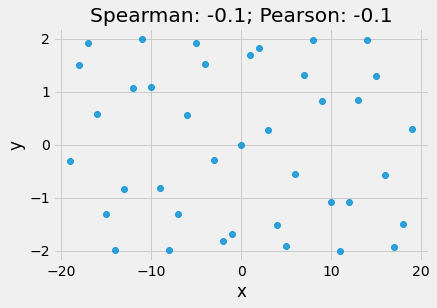

In [169]:
x = np.array(range(-19, 20))
y = 2 * np.sin(x)

plot_corrs(x, y)

우선 모든 변수와 Target의 Pearson 상관관계를 계산해보자.

In [170]:
# train 데이텀나 사용
train_heads = heads.loc[heads['Target'].notnull(),:].copy()

pcorrs = pd.DataFrame(train_heads.corr()['Target'].sort_values()).rename(
    columns={'Target':'pcorr'}).reset_index()
pcorrs = pcorrs.rename(columns={'index':'feature'})

print('Most negatively correlated variables :')
print(pcorrs.head())

print('\nMost positively correlated variables :')
print(pcorrs.dropna().tail())

Most negatively correlated variables :
        feature     pcorr
0       warning -0.301791
1     hogar_nin -0.266309
2          r4t1 -0.260917
3  overcrowding -0.234954
4         eviv1 -0.217908

Most positively correlated variables :
               feature     pcorr
97   phones-per-capita  0.299026
98               floor  0.307605
99    walls+roof+floor  0.332446
100           meaneduc  0.333652
101             Target  1.000000


음의 상관관계의 경우, 변수를 늘리면 빈곤 심각성의 증가를 나타내는 Target이 감소한다. 그러므로 warning이 증가함에 따라 빈곤 수준 또한 증가하는데, 집에 대한 잠재적인 안 좋은 징후를 보여주기 위한 것이었으므로 적합하다. hogar_nin은 가정의 0~19의 아이들 수로, 어린 아이들은 더 빈곤한 가정에 재정적 스트레스가 될 수 있다. 또는 사회 경제적 지위가 낮은 가정은 그들 중 한 명이 성공할 수 있기를 바라는 희망으로 더 많은 아이를 낳는다. 이유가 어떻든 가족의 크기와 빈곤 사이에는 실질적 연관성이 있다.

반면, 양의 상관관계의 경우, 값이 높을수록 빈곤 심각성의 감소를 나타내는 Target값이 증가한다. 가장 상관관계가 높은 가구 수준 변수는 가구 내 성인의 평균 교육 수준인 meaneduc이다. 교육과 빈곤의 관계는, 더 높은 수준의 교육이 일반적으로 낮은 빈곤 수준과 관련있으므로 적합하다. 원인은 알 수 없지만 같은 방향으로 움직이는 경향이 있음을 알 수 있다.

상관관계
- .00 - .19 : 매우 약함
- .20 - .39 : 약함
- .40 - .59 : 보통
- .60 - .79 : 강함
- .80 - 1.0 : 매우 강함

이러한 상관관계는 모델이 변수에서 Target으로 매핑하는 걸 학습하는 데 사용할 수 있는 약한 관계가 있다는 걸 보여준다.

이제 Spearman 상관관계로 넘어가자.

In [172]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

feats = []
scorr = []
pvalues = []

# 각 열 반복
for c in heads:
    # 유효한 숫자만
    if heads[c].dtype != 'object':
        feats.append(c)
        
        # spearman 상관관계 계산
        scorr.append(spearmanr(train_heads[c],train_heads['Target']).correlation)
        pvalues.append(spearmanr(train_heads[c],train_heads['Target']).pvalue)
        
scorrs = pd.DataFrame({'feature':feats, 'scorr':scorr, 'pvalue':pvalues}).sort_values('scorr')

Spearman 상관관계 계산은 관계의 유의수준을 나타내는 pvalue값도 제공된다. 0.05보다 작은 pvalue는 일반적으로 유의한 것으로 간주되지만, 다중 비교이므로 pvalue를 비교 횟수로 나누어 Bonferroni 보정을 한다.

In [173]:
print('Most negative Spearman correlations:')
print(scorrs.head())
print('\nMost positive Spearman correlations:')
print(scorrs.dropna().tail())

Most negative Spearman correlations:
       feature     scorr        pvalue
97     warning -0.307326  4.682829e-66
68  dependency -0.281516  2.792620e-55
85   hogar_nin -0.236225  5.567218e-39
80        r4t1 -0.219226  1.112230e-33
49       eviv1 -0.217803  2.952571e-33

Most positive Spearman correlations:
              feature     scorr        pvalue
23          cielorazo  0.300996  2.611808e-63
95              floor  0.309638  4.466091e-67
99  phones-per-capita  0.337377  4.760104e-80
96   walls+roof+floor  0.338791  9.539346e-81
0              Target  1.000000  0.000000e+00


대부분의 경우 상관관계를 계산하는 두 방법이 일치한다. 단지 호기심으로 멀리 떨어져있는 값을 찾아보자.

In [174]:
corrs = pcorrs.merge(scorrs, on='feature')
corrs['diff'] = corrs['pcorr'] - corrs['scorr']

corrs.sort_values('diff').head()

,feature,pcorr,scorr,pvalue,diff
77,rooms-per-capita,0.152185,0.223303,6.521453e-35,-0.071119
85,v18q1,0.197493,0.244200,1.282664e-41,-0.046708
87,tablets-per-capita,0.204638,0.248642,3.951568e-43,-0.044004
2,r4t1,-0.260917,-0.219226,1.112230e-33,-0.041691
97,phones-per-capita,0.299026,0.337377,4.760104e-80,-0.038351


In [175]:
corrs.sort_values('diff').dropna().tail()

,feature,pcorr,scorr,pvalue,diff
57,techozinc,0.014357,0.003404,8.528369e-01,0.010954
49,hogar_mayor,-0.025173,-0.041722,2.290994e-02,0.016549
88,edjefe,0.235687,0.214736,2.367521e-32,0.020951
66,edjefa,0.052310,0.005114,7.804715e-01,0.047197
17,dependency,-0.126465,-0.281516,2.792620e-55,0.155051


dependency가 두 상관관계값이 가장 다르다. dependency 대비 Target의 scatterplot을 통해 관계를 시각화할 수 있다. 두 변수 모두 이산형이므로 jitter를 조금 추가한다.

Text(0.5, 1.0, 'Target vs Dependency')

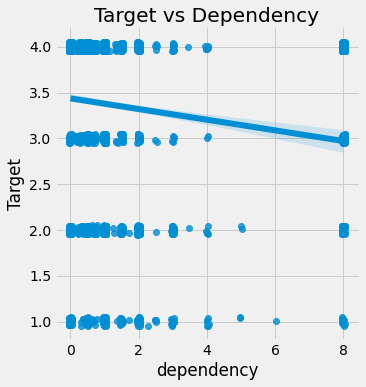

In [176]:
sns.lmplot('dependency','Target',fit_reg=True,data=train_heads,x_jitter=0.05,y_jitter=0.05)
plt.title('Target vs Dependency')

관계를 확인하기 어렵지만 dependency가 증가할수록 Target값이 감소하므로 약간 음의 상관관계다. dependency는 의존적인 개인 수를 의존적이지 않은 개인 수로 나눈 것이므로 적합하다. 의존적인 가족이 많으면 비의존적인 가족 구성원의 도움을 받아야하므로 빈곤 수준이 더 높아지기 때문에, 이 값이 증가하면 빈곤 심각성도 증가하는 경향이 있다. 

Text(0.5, 1.0, 'Target vs Rooms Per Capita')

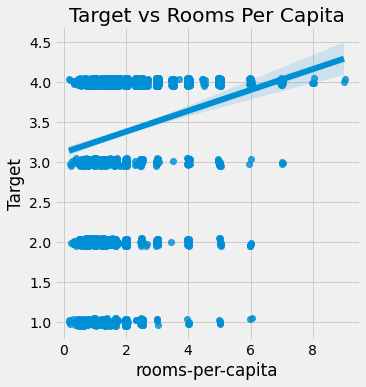

In [177]:
sns.lmplot('rooms-per-capita','Target', fit_reg=True,data=train_heads,x_jitter=0.05,y_jitter=0.05)
plt.title('Target vs Rooms Per Capita')